In [23]:
!pip install adversarial-robustness-toolbox

In [24]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.optimizers import RMSprop

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import adam_v2
from keras import backend as K

from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, UniversalPerturbation, SaliencyMapMethod
from art.estimators.classification import KerasClassifier

# Set the random seeds. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Defining some constants
NUM_CLASSES = 10
BATCH_SIZE = 64

## Setting up things

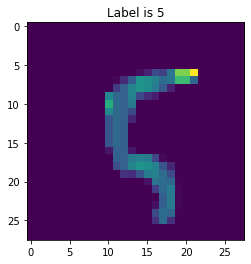

In [25]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.all_utils.normalize(x_train, axis=1)
x_test = keras.utils.all_utils.normalize(x_test, axis=1)

# Plot an example image (after normalization) from the train set
plt.title('Label is {}'.format(y_train[100]))
plt.imshow(x_train[100])
plt.show()

# convert class vectors to binary class matrices
y_train = keras.utils.all_utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.all_utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

## Train CNN based model

### You need to complete the following.

In [26]:
# Define the CNN network architecture. 
cnn_based_model = Sequential()

# Define the intermediate layers.
# Conv1 layer
cnn_based_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
cnn_based_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation="relu"))
cnn_based_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
cnn_based_model.add(Dropout(0.2))

cnn_based_model.add(Flatten())
cnn_based_model.add(Dense(128, activation='relu'))
cnn_based_model.add(Dropout(0.5))
cnn_based_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [27]:
# Compile the CNN model. 
cnn_based_model.compile(loss=categorical_crossentropy, optimizer=adam_v2.Adam(learning_rate=0.01), metrics=["accuracy"])

cnn_based_classifier = KerasClassifier(model=cnn_based_model, clip_values=(0,1))
cnn_based_classifier.fit(x_train, y_train, nb_epochs=5, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = cnn_based_classifier.predict(x_test)

# Compute the accuracy on the test set.
cnn_score = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]

print('Test accuracy:', cnn_score)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 210us/sample - loss: 0.2266 - accuracy: 0.9330
Epoch 2/5
60000/60000 [==============================] - 12s 206us/sample - loss: 0.1339 - accuracy: 0.9603
Epoch 3/5
60000/60000 [==============================] - 12s 205us/sample - loss: 0.1313 - accuracy: 0.9626
Epoch 4/5
60000/60000 [==============================] - 12s 205us/sample - loss: 0.1161 - accuracy: 0.9673
Epoch 5/5
60000/60000 [==============================] - 12s 208us/sample - loss: 0.1109 - accuracy: 0.9683


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test accuracy: 0.9858


## Train ANN based model (dense layers only)

### You need to complete the following.

In [28]:
# Train and Test sets for ANN
x_train_ann = x_train.reshape(60000, 784)
x_test_ann = x_test.reshape(10000, 784)

# Define the ANN network architecture.
ann_based_model = Sequential()

# Define the intermediate layers.
ann_based_model.add(Dense(256, activation="sigmoid", input_shape=x_train_ann.shape[1:]))
ann_based_model.add(Dropout(0.2))
ann_based_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [29]:
# Compile the ANN model. 
ann_based_model.compile(loss=categorical_crossentropy, optimizer=adam_v2.Adam(learning_rate=0.01), metrics=["accuracy"])

In [30]:
ann_based_classifier = KerasClassifier(model=ann_based_model, clip_values=(0,1))
ann_based_classifier.fit(x_train_ann, y_train, nb_epochs=10, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = ann_based_classifier.predict(x_test_ann)

# Compute the accuracy on the test set.
ann_score = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]

print('Test accuracy:', ann_score)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2849 - accuracy: 0.9142
Epoch 2/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.1255 - accuracy: 0.9621
Epoch 3/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0886 - accuracy: 0.9726
Epoch 4/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0702 - accuracy: 0.9772
Epoch 5/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0593 - accuracy: 0.9805
Epoch 6/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0522 - accuracy: 0.9828
Epoch 7/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0468 - accuracy: 0.9847
Epoch 8/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0410 - accuracy: 0.9865
Epoch 9/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0377 - accuracy: 0.9874
Epoch 10/10
60

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test accuracy: 0.9767


## Compare the classification accuracy on the test data graphically

### You need to complete the following.

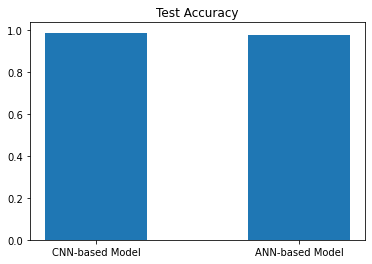

In [31]:
X = ['CNN-based Model','ANN-based Model']
Y = [cnn_score, ann_score]
plt.bar(X, Y, width=(0.5))
plt.title('Test Accuracy')
plt.show()
plt.close()

## Part 2: Generate adversarial examples using four methods

### You need to complete the following.

In [32]:
def generate_adv_examples_FGSM(classifier, x):
    # This attack is known as the "Fast Gradient Sign Method".
    attack = FastGradientMethod(classifier, eps=0.1)
    return attack.generate(x)

def generate_adv_examples_BasicIterativeMethod(classifier, x):
    # The Basic Iterative Method is the iterative version of FGM and FGSM.
    attack = BasicIterativeMethod(classifier, eps=0.1, verbose=False)
    return attack.generate(x)

def generate_adv_examples_SaliencyMapMethod(classifier, x):
    # attack from the Jacobian-based Saliency Map Attack (Papernot et al. 2016).
    # Paper link: https://arxiv.org/abs/1511.07528
    attack = SaliencyMapMethod(classifier, theta=1, verbose=False)
    return attack.generate(x)

def generate_adv_examples_UniversalPerturbation(classifier, x):
    attack = UniversalPerturbation(classifier, eps=0.1, verbose=False)
    return attack.generate(x)

In [33]:
# Generate examples for CNN-based model
# The execution takes a lot of time for all the 10000 examples, so generating only 8 adverserial examples here to display below.
# To find the accuracy later, all the 10000 examples are used.
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier, x_test[0:8])
cnn_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(cnn_based_classifier, x_test[0:8])
cnn_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(cnn_based_classifier, x_test[0:8])
cnn_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(cnn_based_classifier, x_test[0:8])

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

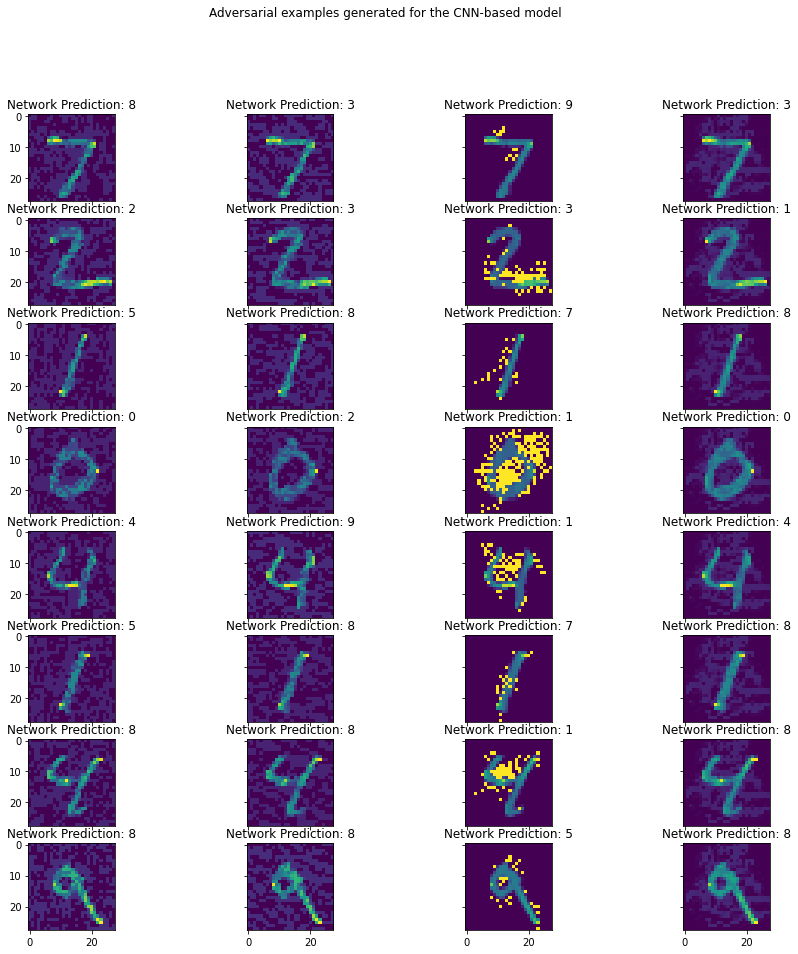

In [34]:
# Generate plot
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the CNN-based model')
cnn_adv_examples = [cnn_adv_examples_FGSM,cnn_adv_examples_BasicIterativeMethod,cnn_adv_examples_SaliencyMapMethod,cnn_adv_examples_UniversalPerturbation]

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(cnn_adv_examples[j][i].squeeze())
        predictions = cnn_based_classifier.predict(np.expand_dims(cnn_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

In [35]:
# Generate examples for ANN-based model
# The execution takes a lot of time for all the 10000 examples, so generating only 8 adverserial examples here to display below.
# To find the accuracy later, all the 10000 examples are used.
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier, x_test_ann[0:8])
ann_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(ann_based_classifier, x_test_ann[0:8])
ann_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(ann_based_classifier, x_test_ann[0:8])
ann_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(ann_based_classifier, x_test_ann[0:8])

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

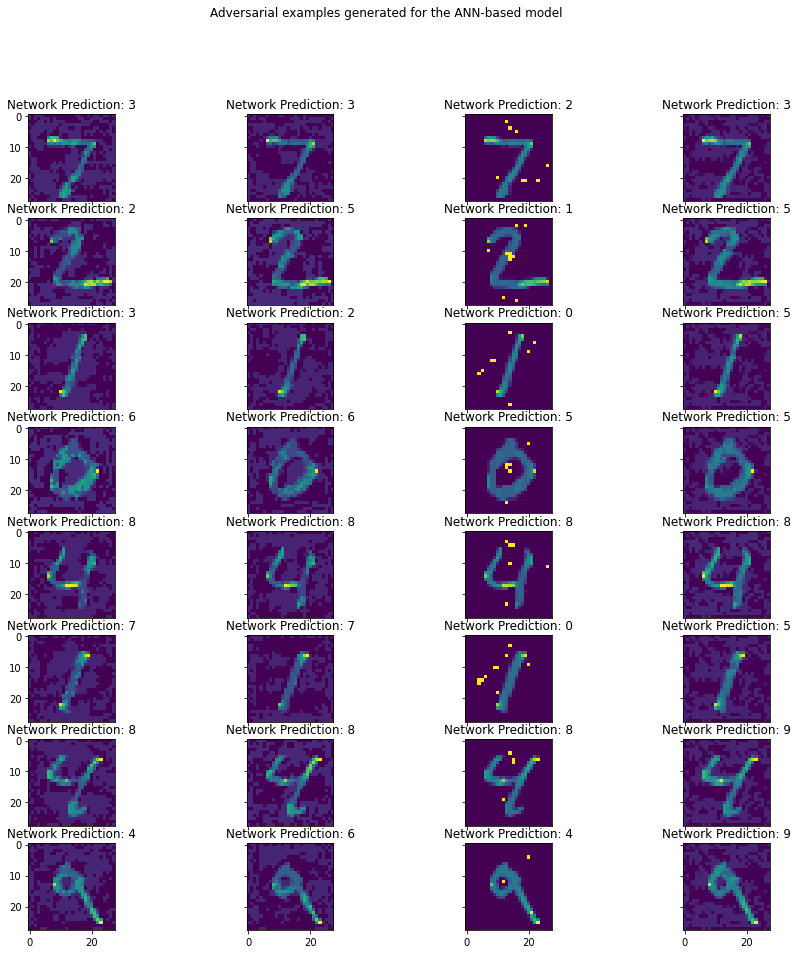

In [36]:
# Generate plots
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the ANN-based model')

ann_adv_examples_FGSM=ann_adv_examples_FGSM.reshape(ann_adv_examples_FGSM.shape[0], 1, 28, 28)
ann_adv_examples_BasicIterativeMethod=ann_adv_examples_BasicIterativeMethod.reshape(ann_adv_examples_BasicIterativeMethod.shape[0], 1, 28, 28)
ann_adv_examples_SaliencyMapMethod=ann_adv_examples_SaliencyMapMethod.reshape(ann_adv_examples_SaliencyMapMethod.shape[0], 1, 28, 28)
ann_adv_examples_UniversalPerturbation=ann_adv_examples_UniversalPerturbation.reshape(ann_adv_examples_UniversalPerturbation.shape[0], 1, 28, 28)

ann_adv_examples = [ann_adv_examples_FGSM,ann_adv_examples_BasicIterativeMethod,ann_adv_examples_SaliencyMapMethod,ann_adv_examples_UniversalPerturbation]

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(ann_adv_examples[j][i].squeeze())
        predictions = ann_based_classifier.predict(np.expand_dims((ann_adv_examples[j][i].reshape(784)), 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

## Part 3: Create a new test set, based entirely on the adversarial images generated previously. Test your classifiers performance on this test set.

### You need to complete the following.

In [37]:
# We will be using the FGSM method in this part
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier, x_test_ann)
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier, x_test)

In [38]:
# Evaluate ANN-based-classifier on the newly generated adversarial test set
predictions = ann_based_classifier.predict(ann_adv_examples_FGSM)
ann_based_score = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
ann_adv_score = ann_based_score
print('ANN-based Model Score: {}'.format(ann_based_score))

ANN-based Model Score: 0.1288


In [39]:
# Evaluate CNN-based-classifier on the newly generated adversarial test set
predictions = cnn_based_classifier.predict(cnn_adv_examples_FGSM)
cnn_based_score = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
cnn_adv_score = cnn_based_score
print('CNN-based Model Score: {}'.format(cnn_based_score))

CNN-based Model Score: 0.4281


## Create a new augmented test set (original test images + adversarial images)


### You need to complete the following.

In [40]:
# ANN-based-classifier
ann_augmented_examples = []
ann_augmented_examples = np.zeros((10000,784))

for i in range(10000):  
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        ann_augmented_examples[i] = ann_adv_examples_FGSM[i]
    # Select actual samples.
    else:
        ann_augmented_examples[i] = x_test_ann[i]
        
# ann_augmented_examples = np.concatenate(ann_augmented_examples, axis=0)

predictions = ann_based_classifier.predict(ann_augmented_examples)
ann_based_score = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
augmented_ann_score = ann_based_score
print('ANN-based Model Score: {}'.format(ann_based_score))

ANN-based Model Score: 0.5526


In [41]:
# CNN-based-classifier
cnn_augmented_examples = []
cnn_augmented_examples = np.zeros((10000,1,28,28))

for i in range(10000):  
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        cnn_augmented_examples[i] = cnn_adv_examples_FGSM[i]
    # Select actual samples.
    else:
        cnn_augmented_examples[i] = x_test[i]

# cnn_augmented_examples = np.concatenate(cnn_augmented_examples, axis=0)
predictions = cnn_based_classifier.predict(cnn_augmented_examples)
cnn_based_score = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
augmented_cnn_score = cnn_based_score
print('CNN-based Model Score: {}'.format(cnn_based_score))

CNN-based Model Score: 0.7038


## Make a single plot, wherein you compare the test accuracies of all the models, on the three types of test sets that you have

### You need to complete the following.

In [42]:
ann_models_score = ann_based_score
cnn_models_score = cnn_based_score

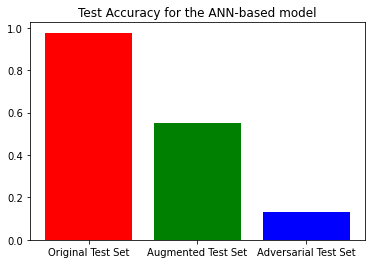

In [43]:
# Plot for the ANN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
Y = [ann_score, augmented_ann_score, ann_adv_score]
plt.bar(X, Y, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the ANN-based model')
plt.show()
plt.close()

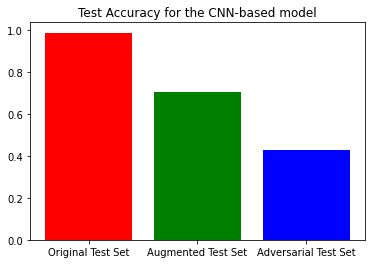

In [44]:
# Plot for the CNN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
Y = [cnn_score, augmented_cnn_score, cnn_adv_score]
plt.bar(X, Y, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the CNN-based model')
plt.show()
plt.close()

In [46]:
print('The performance of the models reduce on augmented test data and further dips of adverserial test set. Therefore, we can infere that a model can be compromised and its accuracy can be reduced with the introduction of adverserial samples in the test set.')

The performance of the models reduce on augmented test data and further dips of adverserial test set. Therefore, we can infere that a model can be compromised and its accuracy can be reduced with the introduction of adverserial samples in the test set.
